# MNIST dataset on the Kria KV260 FPGA


The dataset we chose is the MNIST digits classification dataset (https://en.wikipedia.org/wiki/MNIST_database), consisting of 60000 training / 10000 test images of 28*28 pixels of digits 0-9.

Quantization-aware training was performed on PyTorch using the Brevitas library to have a model with the following features:
1. MNIST input layer quantized to 8 bit integers (784) and integer output layer (10)
2. 2 Densely connected hidden layers (512, 256)
3. Quantized Tanh() activation function for 8 bit integer intermediates
4. 8-bit integers weights and 32-bit integers biases

We will first demonstrate the software implementation running on the Kria KV260 ARM Cortex-A53 processor.

## Software Implementation
We first load in all dependencies used in this demo. PYNQ is used to provide a python API to interface with the PL. time and tqdm packages are used to track the time taken for the various implementation, while numpy and pandas are to import the various CSVs as well as run the software implementation.

In [1]:
import pynq
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
from pynq import Overlay, allocate, PL

To start, we first load in the weights and biases used in our design, as well as the test set which consists of 10000 images with labels. Note that the weights and biases are large and may take a while to load in fully.

In [12]:
# Load weights and biases
filename = "weights_bias.csv"
print("Loading weights and biases from {}...".format(filename))
weights = pd.read_csv(filename, header=None, dtype=np.int32).values.flatten()
print(f"Loaded weights/biases of size {len(weights)} succesfully.")

# Load in test set
filename = "test.csv"
print("Loading input data from {}...".format(filename))
test = pd.read_csv(filename, header=0).values
print(f"Loaded test set of size {len(test)} successfully.")

# Split into inputs and labels
inputs = test[:, :-1].astype(np.float32)
labels = test[:, -1]  # Extract last column as labels

Loading weights and biases from weights_bias.csv...
Loaded weights/biases of size 535818 succesfully.
Loading input data from test.csv...
Loaded test set of size 10000 successfully.


Next, we run the software implementation of our model on our test set to take note of the accuracy and time taken.

In [13]:
# Define layer dimensions
input_dim = 784
hidden1_dim = 512
hidden2_dim = 256
output_dim = 10

# Sizes for each parameter block
W1_size = input_dim * hidden1_dim       # 784 * 512
b1_size = hidden1_dim                   # 512
W2_size = hidden1_dim * hidden2_dim       # 512 * 256
b2_size = hidden2_dim                   # 256
W3_size = hidden2_dim * output_dim      # 256 * 10
b3_size = output_dim                    # 10

# Partitioning of weights and biases
offset = 0
W1 = weights[offset: offset + W1_size].astype(np.int8).reshape(hidden1_dim, input_dim)
offset += W1_size

b1 = weights[offset: offset + b1_size].astype(np.int32)
offset += b1_size

W2 = weights[offset: offset + W2_size].astype(np.int8).reshape(hidden2_dim, hidden1_dim)
offset += W2_size

b2 = weights[offset: offset + b2_size].astype(np.int32)
offset += b2_size

W3 = weights[offset: offset + W3_size].astype(np.int8).reshape(output_dim, hidden2_dim)
offset += W3_size

b3 = weights[offset: offset + b3_size].astype(np.int32)


# Fully connected layer with Tanh() activation
def fc_tanh(x, W, b, scale):
    sum = np.dot(W.astype(np.int32), x.astype(np.int32)) + b
    # Apply the tanh activation (output will be between -1 and 1)
    sum_scaled = sum * scale
    x_tanh = np.tanh(sum_scaled)
    # Clip it back to -127 to 128
    x_tanh_int8 = np.clip(np.round(x_tanh * 127), -128, 127).astype(np.int8)
    return x_tanh_int8

# Fully connected layer
def fc(x, W, b):
    sum = np.dot(W.astype(np.int32), x.astype(np.int32)) + b
    return sum

# Scale factors (Extracted from Brevitas Model)
scale_fc1 = 0.0002452194457873702 / 0.0078125
scale_fc2 = 0.000244140625 / 0.0078125

# Run inference and measure time taken
correct = 0
start_time = time.time()

for i in tqdm(range(len(inputs)), desc="Processing inputs"):
    x = inputs[i]
    # Round to int8
    x_int8 = np.clip(np.round(x * 127), -128, 127).astype(np.int8)
    a1 = fc_tanh(x_int8, W1, b1, scale_fc1)
    a2 = fc_tanh(a1, W2, b2, scale_fc2)
    output = fc(a2, W3, b3)
    predicted_label = np.argmax(output)
    # Compare with true label
    if predicted_label == labels[i]:
        correct += 1
end_time = time.time()

print(f"Number of inputs: {len(inputs)}")
print(f"Accuracy: {correct / len(inputs) * 100}%")
print(f"Time taken: {end_time - start_time} seconds")
print(f"Time taken per inference: {(end_time - start_time)/len(inputs)} seconds")

Processing inputs: 100%|██████████| 10000/10000 [00:36<00:00, 272.48it/s]

Number of inputs: 10000
Accuracy: 96.89%
Time taken: 36.70844340324402 seconds
Time taken per inference: 0.003670844340324402 seconds


## HLS Implementation

The MLP model deployed on the KV260 tries to achieves high utilization of resources as well as providing low latency inference. 

Optimization done in Vitis HLS:

1. Able to load in weights and biases dynamically at start
2. Utilizes BRAM, LUTRAM, URAM to deploy as large a model as possible
3. ap_int<8> weights and ap_int<32> biases to allow for larger model
2. Fully unrolled layers
3. HLS pipeline of II = 4 for inference flow, II = 1 for input and output
4. Approximated tanh() function to reduce DSP usage
|
With this optimizations, we were able to deploy a model with high accuracy (4-layer deep neural network) of over 96.8% on the KV260 FPGA with sufficient resources (utilizing integer based data storage, approximate computation methods) with low latency inference (full unrolling + pipeline II = 4).

## Vitis synthesis results:
Inference end to end latency: 796 + 2488 + 1327 + 174 + 1 = 4786 clock cycles

Effective II: 796 + 4 + 4 + 4 + 1 = 809 clock cycles
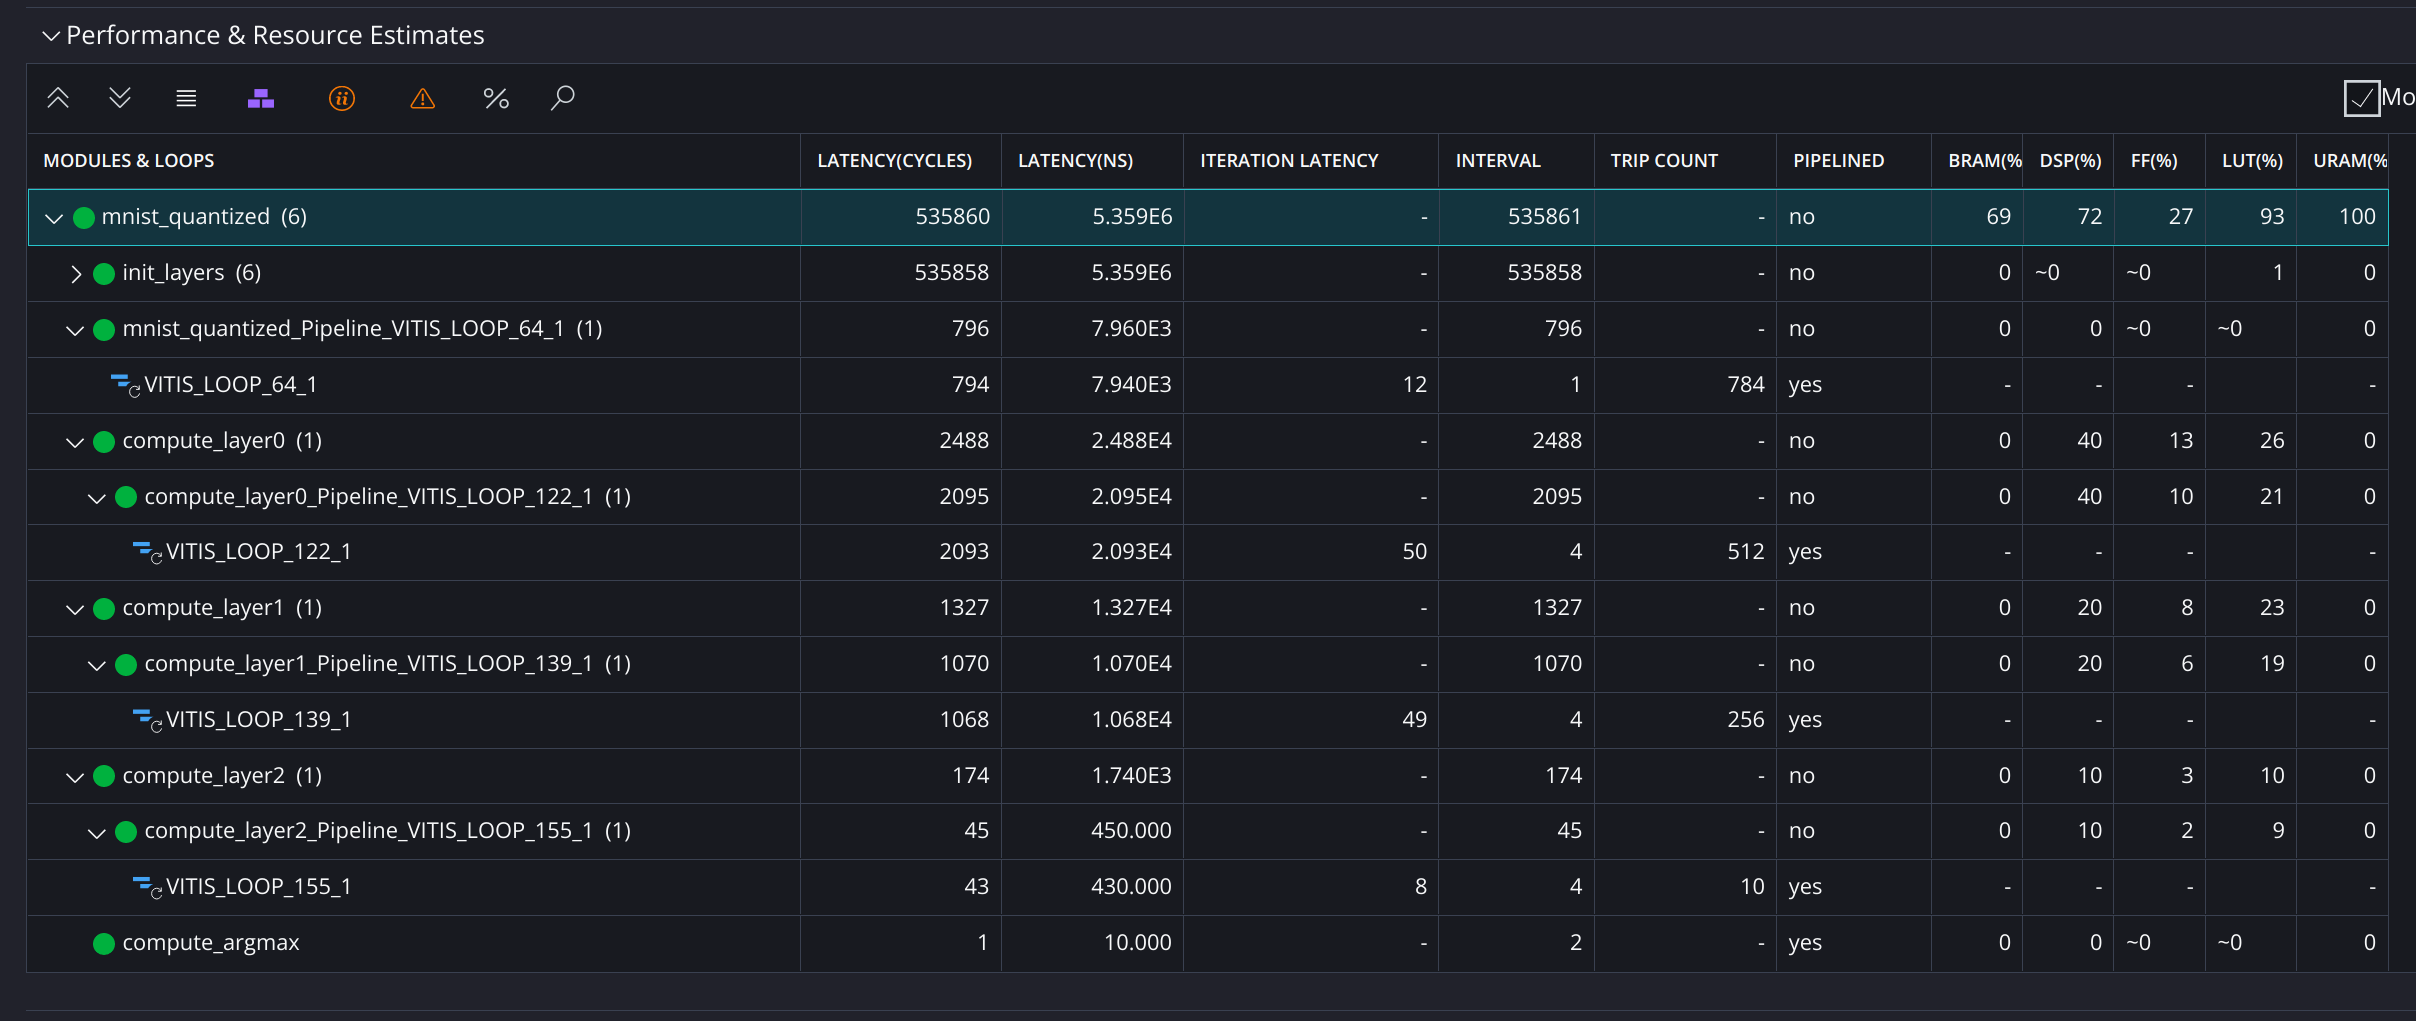

## Vitis Array partitioning:
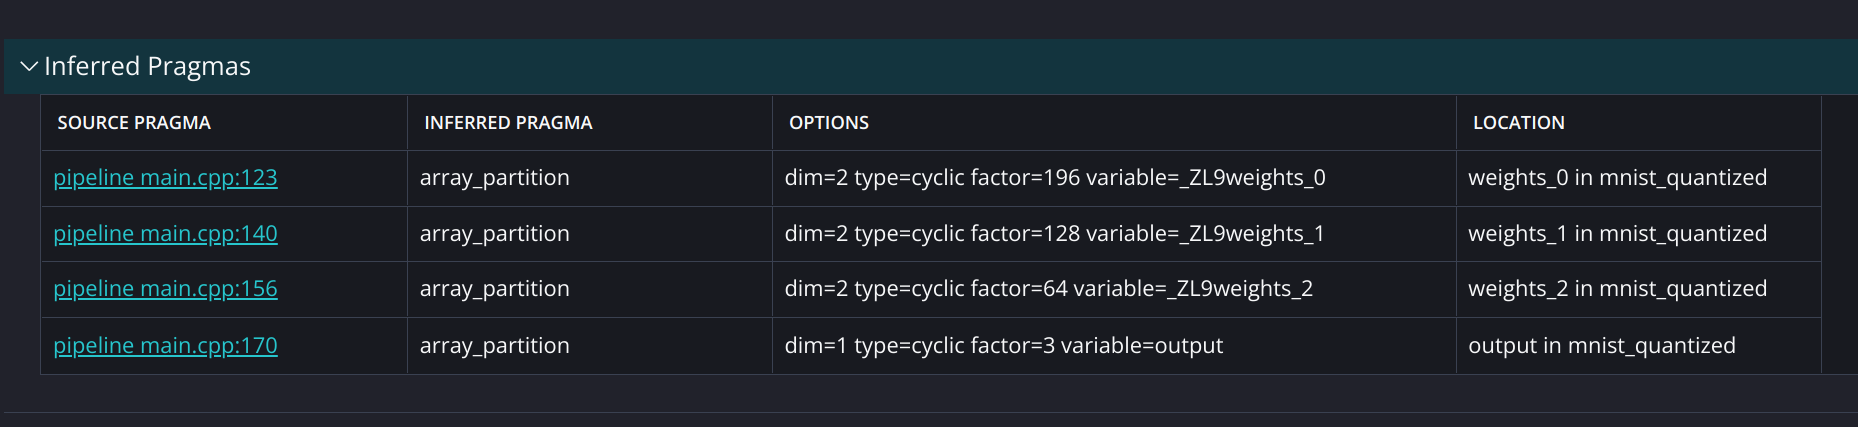

## Vivado utilization results:
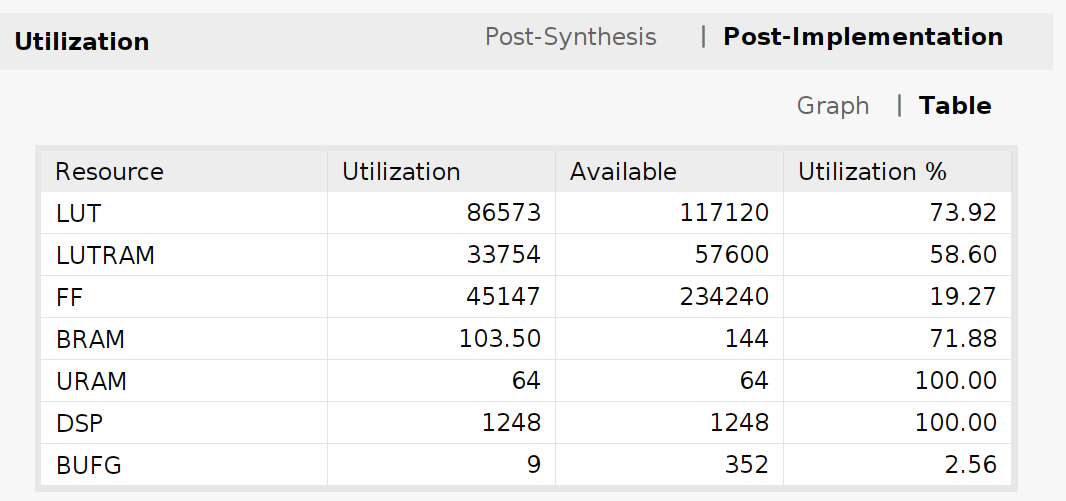


## Vivado timing results:
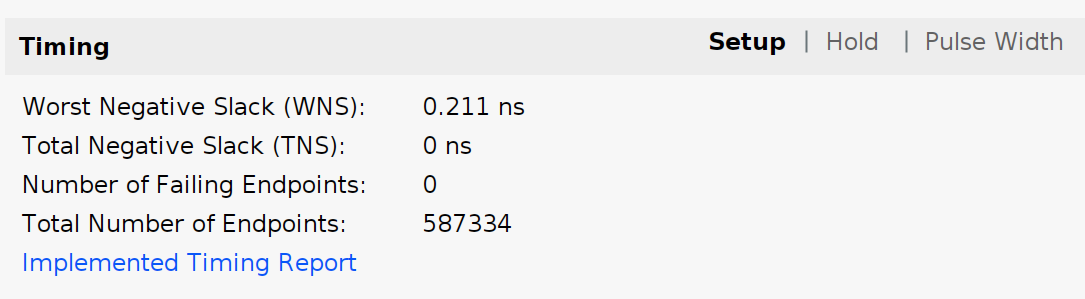

To test out our HLS implementation, first we import our bitstream and hardware design file. We then instantiate the relevant IP cores in our design (DMA and our HLS IP).

In [ ]:
PL.reset()
ol = Overlay("Models/MNIST_HLS.bit")

# DMA
dma = ol.axi_dma_0
dma_send = dma.sendchannel
dma_recv = dma.recvchannel

# HLS IP
hls_ip = ol.mnist_quantized_0
CONTROL_REGISTER = 0x0
hls_ip.write(CONTROL_REGISTER, 0x81) # Starts the IP core
print("Done with overlaying design.")

Done with overlaying design.


We then stream our weights and biases into the FPGA upon initialization.

In [15]:
input_buf = allocate(shape=(len(weights),), dtype=np.int32)
input_buf[:] = weights[:]
startTime = time.time()
# Transmit weights and biases into FPGA
input_buf.flush()
dma.sendchannel.transfer(input_buf)
dma.sendchannel.wait()
endTime = time.time()
print(f"All weights and biases successfully transferred to Kria KV260 in {endTime - startTime} seconds.")

#Clean up the temporary buffer
input_buf.close()

All weights and biases successfully transferred to Kria KV260 in 0.004549741744995117 seconds.


Next, we run the HLS implementation of our model on our test set to take note of the accuracy and time taken.

In [16]:
# Inference
input_buffer = allocate(shape=(784,), dtype=np.float32)  # 784 input feature
output_buffer = allocate(shape=(1,), dtype=np.int32)  # Assuming single output label
# Run inference
correct = 0
startTime = time.time()

for i in tqdm(range(len(inputs)), desc="Running Inference"):
    input_buffer[:] = inputs[i]
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

    # predicted vs actual
    predicted_label = output_buffer[0]
    actual_label = labels[i]
    
    if predicted_label == actual_label:
        correct += 1

endTime = time.time()

print(f"Number of inputs: {len(inputs)}")
print(f"Accuracy: {correct / len(inputs) * 100}%")
print(f"Time taken: {endTime - startTime} seconds")
print(f"Time taken per inference: {(endTime - startTime)/len(inputs)} seconds")

Running Inference: 100%|██████████| 10000/10000 [00:04<00:00, 2416.25it/s]

Number of inputs: 10000
Accuracy: 96.88%
Time taken: 4.1472368240356445 seconds
Time taken per inference: 0.00041472368240356446 seconds


The HLS model takes 4+ seconds and achieves similar accuracy as compared to 37+ seconds on the Python software implementation (About 8.7x faster).

Small overheads include the fact that we are using an intepreted language, Python which is generally a bit slower as opposed to a compiler based language like C. We are also using np.tanh() which might be slightly more compute intensive than the FPGA Tanh approximate, to see if accuracy has been negatively affected.

Overall, the FPGA model retains equivalent accuracy(96.88%) as well as providing much faster inference speeds than the software implementation.

## RTL Implementation
Optimization done in RTL:

1. Able to load in weights and biases dynamically at start
2. Utilizes BRAM, LUTRAM, URAM to deploy as large a model as possible
3. ap_int<8> weights and ap_int<32> biases to allow for larger model
2. Partial unrolling of FullyConnected layers (256 multiplications and 4 by 4 adder tree)
3. Partitioning of weights RAM to read 4 values at once (8 bits * 4 = 32 bit tdata)
4. Tanh() function partial unrolling + CORDIC IP and Floating Point IP

With this optimizations, we were able to deploy a model with high accuracy (4-layer deep neural network) of over 96.7% on the KV260 FPGA with sufficient resources, after our various optimizations, we reached a speed comparable to our software model.

## Vivado utilization results:
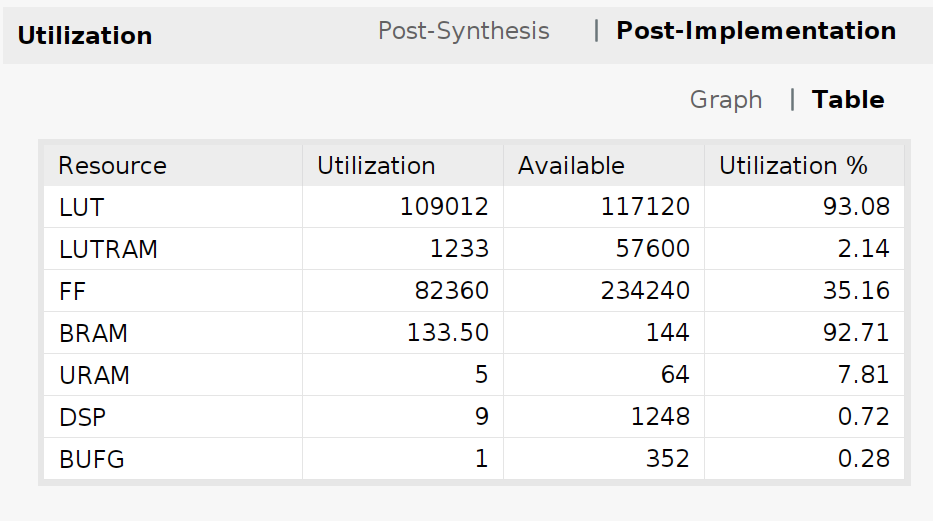

## Vivado timing results:
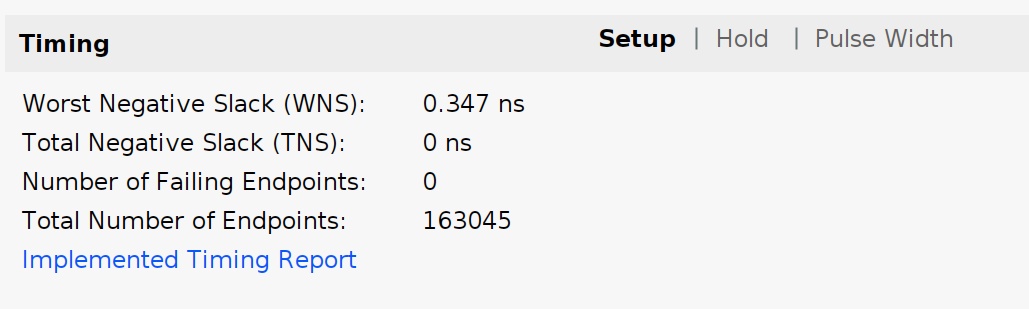

In [20]:
# Load in test set
filename = "test_int8.csv"
print("Loading input data from {}...".format(filename))
test = pd.read_csv(filename, header=0).values
print(f"Loaded test set of size {len(test)} successfully.")

# Split into inputs and labels
inputs = test[:, :-1].astype(np.float32)
labels = test[:, -1]  # Extract last column as labels

Loading input data from test_int8.csv...
Loaded test set of size 10000 successfully.


In [ ]:
PL.reset()
ol = Overlay("Models/MNIST_RTL.bit")

# DMA
dma = ol.axi_dma_0
dma_send = dma.sendchannel
dma_recv = dma.recvchannel

print("Done with overlaying design.")

Done with overlaying design.


In [22]:
# Transfer our weights and bias over first time
input_buf = allocate(shape=(len(weights),), dtype=np.int32)
print(f"Length of weights/bias: {len(input_buf)}")
input_buf[:] = weights[:]
startTime = time.time()

# Transmit weights and biases into FPGA
input_buf.flush()
dma.sendchannel.transfer(input_buf)
dma.sendchannel.wait()
endTime = time.time()
print(f"All weights and biases successfully transferred to Kria KV260 in {endTime - startTime} seconds.")

#Clean up the temporary buffer
input_buf.close()

Length of weights/bias: 535818
All weights and biases successfully transferred to Kria KV260 in 0.00467228889465332 seconds.


In [23]:
# Inference
input_buffer = allocate(shape=(784,), dtype=np.int32)
output_buffer = allocate(shape=(1,), dtype=np.int32)
# Run inference
correct = 0
startTime = time.time()

for i in tqdm(range(len(inputs)), desc="Running Inference"):
    input_buffer[:] = inputs[i]
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    predicted_label = output_buffer
    actual_label = labels[i]

    if predicted_label == actual_label:
        correct += 1

endTime = time.time()
print(f"Number of inputs: {len(inputs)}")
print(f"Accuracy: {correct / len(inputs) * 100}%")
print(f"Time taken: {endTime - startTime} seconds")
print(f"Time taken per inference: {(endTime - startTime)/len(inputs)} seconds")

Running Inference: 100%|██████████| 10000/10000 [00:35<00:00, 284.11it/s]

Number of inputs: 10000
Accuracy: 96.87%
Time taken: 35.20559763908386 seconds
Time taken per inference: 0.003520559763908386 seconds
